In [2]:
"""
Reference: https://www.drivendata.co/blog/predict-pm25-benchmark/

We are going to use some of the explanations regarding satellite data processing with 
geo-location information to help pre-process the data.

The biggest problem with the data is that there are a lot of missing values (or NaN values)

"""
# File manipulation
import os

# Pandas and Numpy
import numpy as np
import pandas as pd

# Date time manipulation
from datetime import datetime, timedelta
from dateutil import parser
import time

# Tensorflow/Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras.backend as backend
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor

# SKlearn
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib.pyplot as plt

# Geo data processing
import geopandas as gpd
from pyhdf.SD import SD, SDC, SDS
import pyproj
from pyproj import CRS, Proj
from typing import Union
from shapely.geometry import Point, Polygon

# Pickle
import pickle

# PQDM for parallel procesing
from pqdm.processes import pqdm


In [23]:
# Inspect one dataset
# We are going to take out some of the attributes we need to generate imputation values later
hdf = SD(os.path.join('train', '20180201T191000_maiac_la_0.hdf'))

for field, data in hdf.datasets().items():
    print(field, "->", data)
    
print("")

blue_band_AOD = hdf.select("Optical_Depth_047")
green_band_AOD = hdf.select("Optical_Depth_055")
aod_uncertainty = hdf.select("AOD_Uncertainty")
finemodefraction = hdf.select("FineModeFraction")
column_wv = hdf.select("Column_WV")
aod_qa = hdf.select("AOD_QA")
aod_model = hdf.select("AOD_MODEL")
injection_height = hdf.select("Injection_Height")
cosSZA = hdf.select("cosSZA")
cosVZA = hdf.select("cosVZA")
relAZ = hdf.select("RelAZ")
scattering_angle = hdf.select("Scattering_Angle")
glint_angle = hdf.select("Glint_Angle")

Optical_Depth_047 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 0)
Optical_Depth_055 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 1)
AOD_Uncertainty -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 2)
FineModeFraction -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 3)
Column_WV -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 4)
AOD_QA -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 23, 5)
AOD_MODEL -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 21, 6)
Injection_Height -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 5, 7)
cosSZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 8)
cosVZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 9)
RelAZ -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 2

In [4]:
raw_attr = hdf.attributes()["StructMetadata.0"] # Look at Metadata
print(raw_attr)
group_1 = raw_attr.split("END_GROUP=GRID_1")[0] # Pick out only 5km field in the metadata
# print(group_1)

hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except (NameError, ValueError, SyntaxError):
        hdf_metadata[key] = val

for key, value in hdf_metadata.items():
    print(key, '->', value)

print("")
    
# Note that coordinates are provided in meters
# We construct an alignment dictionary parameter
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

for key, value in alignment_dict.items():
    print(key, '->', value)


GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [7]:
##################
#DATA PROCESSING #
##################
# Loop over orbits to apply the attributes
def calibrate_data(dataset, shape, calibration_dict):
    """
    Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        if 'add_offset' not in calibration_dict:
            offset = 0
        else:
            offset = calibration_dict["add_offset"]
        if 'scale_factor' not in calibration_dict:
            scale_factor = 1
        else:
            scale_factor = calibration_dict["scale_factor"]
        data = (
            (data - offset) *
            scale_factor
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

calibration_dict = blue_band_AOD.attributes()
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
# Test calibrate_data function
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)

In [8]:
# Aligning AOD data with real world coordinates
def create_meshgrid(alignment_dict, shape):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

xv, yv = create_meshgrid(alignment_dict, shape)

In [9]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

In [10]:
def convert_array_to_df(
    corrected_arr,
    lat,
    lon,
    granule_id,
    crs,
    total_bounds = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

def plot_gdf(gdf, separate_bands=True, title='Blue Band AOD'):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle(title, fontsize=12)

(1203568, 4)
                       granule_id  orbit                     geometry  value
0  20180201T191000_maiac_la_0.hdf      0  POINT (-110.79078 35.36280)  0.110
1  20180201T191000_maiac_la_0.hdf      0  POINT (-110.78956 35.35446)  0.076
2  20180201T191000_maiac_la_0.hdf      0  POINT (-110.28947 35.28774)  0.112


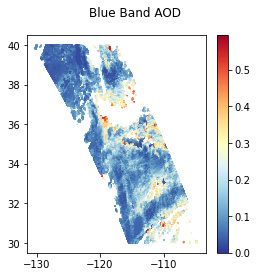

In [11]:
gdf = convert_array_to_df(corrected_AOD, lat, lon, '20180201T191000_maiac_la_0.hdf', wgs84_crs)
print(gdf.shape)
print(gdf.head(3))

plot_gdf(gdf, separate_bands=False)

In [13]:
hdf.end()  # Close hdf file to free up memory

In [14]:
# Some more helpful functions from the tutorial
def create_calibration_dict(data):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()

def create_alignment_dict(hdf):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [15]:
# Importing HDF data and creating a set of raw hdf files.
train_labels = pd.read_csv("train_labels.csv")
train_labels['Date'] = pd.to_datetime(train_labels['datetime'], format='%Y-%m-%d')
train_labels['Year'] = train_labels['Date'].dt.year
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

la_gc = grid_metadata[grid_metadata['location'] == "Los Angeles (SoCAB)"].copy()
dl_gc = grid_metadata[grid_metadata['location'] == "Delhi"].copy()
tp_gc = grid_metadata[grid_metadata['location'] == "Taipei"].copy()

# Confirm all LA, Taipei, Delhi grid cells are in our training labels
assert la_gc['grid_id'].isin(train_labels.grid_id).all()
assert dl_gc['grid_id'].isin(train_labels.grid_id).all()
assert tp_gc['grid_id'].isin(train_labels.grid_id).all()

print("LA Grid Len:", len(la_gc))
print("Delhi Grid Len:", len(dl_gc))
print("Taipei Grid Len:", len(tp_gc))

print(train_labels.head(n=10))

# satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
# satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train']
# print(satellite_metadata)
# raw_hdf_set = set(satellite_metadata['granule_id'])

LA Grid Len: 14
Delhi Grid Len: 33
Taipei Grid Len: 7
               datetime grid_id  value                      Date  Year
0  2018-02-01T08:00:00Z   3S31A   11.4 2018-02-01 08:00:00+00:00  2018
1  2018-02-01T08:00:00Z   A2FBI   17.0 2018-02-01 08:00:00+00:00  2018
2  2018-02-01T08:00:00Z   DJN0F   11.1 2018-02-01 08:00:00+00:00  2018
3  2018-02-01T08:00:00Z   E5P9N   22.1 2018-02-01 08:00:00+00:00  2018
4  2018-02-01T08:00:00Z   FRITQ   29.8 2018-02-01 08:00:00+00:00  2018
5  2018-02-01T08:00:00Z   H96P6   12.8 2018-02-01 08:00:00+00:00  2018
6  2018-02-01T08:00:00Z   PG3MI   21.0 2018-02-01 08:00:00+00:00  2018
7  2018-02-01T08:00:00Z   QJHW4    5.2 2018-02-01 08:00:00+00:00  2018
8  2018-02-01T08:00:00Z   WT52R    6.5 2018-02-01 08:00:00+00:00  2018
9  2018-02-01T08:00:00Z   X5DKW   17.7 2018-02-01 08:00:00+00:00  2018


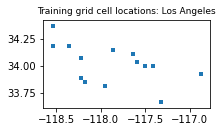

In [16]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

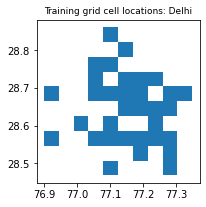

In [17]:
dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

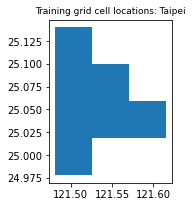

In [18]:
tp_polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs) # used for WGS 84
tp_polys.name = "geometry"
tp_polys_gdf = gpd.GeoDataFrame(tp_polys)

tp_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

In [19]:
# For pqdm if necessary
# !jupyter nbextension enable --py widgetsnbextension

In [20]:
# We split train_labels into train and cross validation

train_actual_labels = train_labels[train_labels['Year'] <= 2019].copy()
train_cross_val_labels = train_labels[train_labels['Year'] > 2019].copy()

# print(len(train_actual_labels.index))
# print(len(train_cross_val_labels.index))

# We randomly pick a few training data points to test the feature generation algorithm
n = 50
train_labels_subset = train_actual_labels.sample(n=n).copy()

def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

def fetch_satellite_meta(metadata, date_time, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(date_time)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

def fetch_granule_id(grid_id, date_time, split):
    temp = get_grid_data(grid_metadata, grid_id)
    location = temp.iloc[0]['location']
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               date_time, 
                               location, 
                               "maiac", 
                               split)
    granule_ids = []
    for i in range(len(sat_met)):
        granule_id = sat_met.iloc[i]['granule_id']
        granule_ids.append(granule_id)
            
    return granule_ids, location

def fetch_alignment_dictionary(hdf, field_name):
    raw_attr = hdf.attributes()["StructMetadata.0"]  # Look at Metadata
    text_array = raw_attr.split("END_GROUP=GRID_1")  # The alignment values are always the same for a given HDF
       
    group_1 = text_array[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

    # Parse expressions still wrapped in apostrophes
    for key, val in hdf_metadata.items():
        try:
            hdf_metadata[key] = eval(val)
        except (NameError, ValueError, SyntaxError):
            hdf_metadata[key] = val

            
    # Note that coordinates are provided in meters
    # We construct an alignment dictionary parameter
    alignment_dict = {
        "upper_left": hdf_metadata["UpperLeftPointMtrs"],
        "lower_right": hdf_metadata["LowerRightMtrs"],
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    
    return alignment_dict

def preprocess_maiac_data(granule_id, location, split, field_name):
    # print(granule_id, location, split, field_name)
    hdf = SD(os.path.join(split, granule_id))
    field = hdf.select(field_name)
    name, num_dim, shape, types, num_attr = field.info()
    if field_name in ['AOD_QA']:
        corrected_field = field
    else:
        calibration_dict = field.attributes()
        corrected_field = calibrate_data(field, shape, calibration_dict)
    alignment_dict = fetch_alignment_dictionary(hdf, field_name)
    xv, yv = create_meshgrid(alignment_dict, shape)
    sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
    wgs84_crs = CRS.from_epsg("4326")
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    if location == "Delhi":
        polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs)
    elif location == "Taipei":
        polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs)
    else:
        polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs)
    
    polys.name = "geometry"
    polys_gdf = gpd.GeoDataFrame(polys)
    
    # xmin, ymin, xmax, ymax = polys_gdf.total_bounds
    gdf = convert_array_to_df(corrected_field, lat, lon, granule_id, wgs84_crs, polys_gdf.total_bounds)
    
    df = gpd.sjoin(polys_gdf, gdf, how="inner")
    
    hdf.end()
    
    return df.drop(columns="index_right").reset_index()

# Parallelize processes
# def preprocess_field_parallel(args, n_jobs=2):
#     args_sub = args[:2]
#     print(args_sub)
#     results = pqdm(args_sub, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
#     return pd.concat(results)

def generate_features(train_labels, split="train"):
    labels = []
    features = []
    args = []
    
    print("Length train_labels:", len(train_labels.index))
    for idx, i in enumerate(train_labels.index): 
        granule_ids, location = fetch_granule_id(train_labels.loc[i]['grid_id'], train_labels.loc[i]['datetime'], split)
    
        blueband_dataframe_list = []
        greenband_dataframe_list = []
        aod_uncertainty_dataframe_list = []
        finemodefraction_dataframe_list = []
        column_wv_dataframe_list = []
        injection_height_dataframe_list = []
#         aod_qa_dataframe_list = []
        
        for granule_id in granule_ids:
            result_blueband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_047'])
            result_greenband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_055'])
            result_aod_uncertainty = preprocess_maiac_data(*[granule_id, location, split, 'AOD_Uncertainty'])
            result_finemodefraction = preprocess_maiac_data(*[granule_id, location, split, 'FineModeFraction'])
            result_column_wv = preprocess_maiac_data(*[granule_id, location, split, 'Column_WV'])
            result_injection_height = preprocess_maiac_data(*[granule_id, location, split, 'Injection_Height'])
#             result_aod_qa = preprocess_maiac_data(*[granule_id, location, split, 'AOD_QA'])
            
            blueband_dataframe_list.append(result_blueband)
            greenband_dataframe_list.append(result_greenband)
            aod_uncertainty_dataframe_list.append(result_aod_uncertainty)
            finemodefraction_dataframe_list.append(result_finemodefraction)
            column_wv_dataframe_list.append(result_column_wv)
            injection_height_dataframe_list.append(result_injection_height)
#             aod_qa_dataframe_list.append(result_aod_qa)
        
        combined_blueband_df = pd.concat(blueband_dataframe_list)
        combined_greenband_df = pd.concat(greenband_dataframe_list)
        combined_aod_uncertainty_df = pd.concat(aod_uncertainty_dataframe_list)
        combined_finemodefraction_df = pd.concat(finemodefraction_dataframe_list)
        combined_column_wv_df = pd.concat(column_wv_dataframe_list)
        combined_injection_height_df = pd.concat(injection_height_dataframe_list)
#         combined_aod_qa_df = pd.concat(aod_qa_dataframe_list)
        
        feature = []
        # Order of statistics: min, max, mean
        if combined_blueband_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_blueband_df['value'].min(), combined_blueband_df['value'].max(), 
                            combined_blueband_df['value'].mean()]) 
        
        if combined_greenband_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_greenband_df['value'].min(), combined_greenband_df['value'].max(), 
                            combined_greenband_df['value'].mean()]) 
        
        if combined_aod_uncertainty_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_aod_uncertainty_df['value'].min(), combined_aod_uncertainty_df['value'].max(), 
                            combined_aod_uncertainty_df['value'].mean()])
            
        if combined_finemodefraction_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_finemodefraction_df['value'].min(), combined_finemodefraction_df['value'].max(), 
                            combined_finemodefraction_df['value'].mean()])
            
        if combined_column_wv_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_column_wv_df['value'].min(), combined_column_wv_df['value'].max(), 
                            combined_column_wv_df['value'].mean()])
        
        if combined_injection_height_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_injection_height_df['value'].min(), combined_injection_height_df['value'].max(), 
                            combined_injection_height_df['value'].mean()])
        
#         if combined_aod_qa_df.empty:
#             feature.extend([np.nan, np.nan, np.nan])
#         else:
#             feature.extend([combined_aod_qa_df['value'].min(), combined_aod_qa_df['value'].max(), 
#                             combined_aod_qa_df['value'].mean()])
        
        label = train_labels.loc[i]['value']
        features.append(feature)
        labels.append(label)
        
    return features, labels

startTime = time.time()
features, labels = generate_features(train_labels_subset, "train")
endTime = time.time()
elapsedTime = endTime - startTime
print("Elapsed time: {}".format(str(timedelta(seconds=elapsedTime))))

Length train_labels: 50
Elapsed time: 0:22:08.808504


In [34]:
"""
Imputation and Scaler
"""

features_array = np.asarray(features)
labels_array = np.asarray(labels)

print(features_array.shape)
print(labels_array.shape)

# print(features_array)

# This function is a custom uniform random imputation function
# This should be updated based on how we generate the features in order to fill all the np.nan values with random valid values
# So if the feature list changes, we have to update this function
def custom_uniform_random_impute_function(features_array, idx_offset=3):
    idx = 0
    
    imputed_features_array = np.copy(features_array)
    
    # N columns are Blueband AOD
    calibration_dict = blue_band_AOD.attributes()
    blue_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of blue band AOD nan:", blue_band_features[np.isnan(blue_band_features)].size)
    blue_band_features[np.isnan(blue_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=blue_band_features[np.isnan(blue_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    blue_band_features = (blue_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    calibration_dict = green_band_AOD.attributes()
    green_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of green band AOD nan:", green_band_features[np.isnan(green_band_features)].size)
    green_band_features[np.isnan(green_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                           high=calibration_dict['valid_range'][1], 
                                                                           size=green_band_features[np.isnan(green_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    green_band_features = (green_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    calibration_dict = aod_uncertainty.attributes()
    aod_uncertainty_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of AOD Uncertainty nan:", aod_uncertainty_features[np.isnan(aod_uncertainty_features)].size)
    aod_uncertainty_features[np.isnan(aod_uncertainty_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                     high=calibration_dict['valid_range'][1], 
                                                                                     size=aod_uncertainty_features[np.isnan(aod_uncertainty_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    aod_uncertainty_features = (aod_uncertainty_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
    idx += idx_offset
    calibration_dict = finemodefraction.attributes()
    finemodefraction_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of FineModeFraction nan:", finemodefraction_features[np.isnan(finemodefraction_features)].size)
    finemodefraction_features[np.isnan(finemodefraction_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                       high=calibration_dict['valid_range'][1], 
                                                                                       size=finemodefraction_features[np.isnan(finemodefraction_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    finemodefraction_features = (finemodefraction_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    calibration_dict = column_wv.attributes()
    column_wv_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of Column WV nan:", column_wv_features[np.isnan(column_wv_features)].size)
    column_wv_features[np.isnan(column_wv_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=column_wv_features[np.isnan(column_wv_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    column_wv_features = (column_wv_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
    idx += idx_offset
    calibration_dict = injection_height.attributes()
    injection_height_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of Injection Height nan:", injection_height_features[np.isnan(injection_height_features)].size)
    injection_height_features[np.isnan(injection_height_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                       high=calibration_dict['valid_range'][1], 
                                                                                       size=injection_height_features[np.isnan(injection_height_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    injection_height_features = (injection_height_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return imputed_features_array
    
imputed_features_array = custom_uniform_random_impute_function(features_array)

# print(imputed_features_array)
print(imputed_features_array.shape)

# This function is a custom Min Max Scaler function
# This should be updated based on how we generate the features
# So if the feature list changes, we have to update this function
def custom_MinMaxScaler_function(features_array, idx_offset=3):
    # y = (x – min) / (max – min)
    idx = 0
    
    transformed_features_array = np.copy(features_array)
    
    min_max_pair_list = []
    
    # N columns are Blueband AOD
    blue_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(blue_band_features)
    max_val = np.amax(blue_band_features)
    blue_band_features = (blue_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    green_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(green_band_features)
    max_val = np.amax(green_band_features)
    green_band_features = (green_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    aod_uncertainty_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(aod_uncertainty_features)
    max_val = np.amax(aod_uncertainty_features)
    aod_uncertainty_features = (aod_uncertainty_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
    idx += idx_offset
    finemodefraction_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(finemodefraction_features)
    max_val = np.amax(finemodefraction_features)
    finemodefraction_features = (finemodefraction_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    column_wv_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(column_wv_features)
    max_val = np.amax(column_wv_features)
    column_wv_features = (column_wv_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
    idx += idx_offset
    injection_height_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(injection_height_features)
    max_val = np.amax(injection_height_features)
    injection_height_features = (injection_height_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return transformed_features_array, min_max_pair_list

transformed_features_array, min_max_pair_list = custom_MinMaxScaler_function(imputed_features_array)

# print(transformed_features_array)
print(transformed_features_array.shape)
print(min_max_pair_list)

(50, 18)
(50,)
Number of blue band AOD nan: 18
Number of green band AOD nan: 18
Number of AOD Uncertainty nan: 0
Number of FineModeFraction nan: 150
Number of Column WV nan: 0
Number of Injection Height nan: 120
(50, 18)
(50, 18)
[(-0.05626387750736651, 4.248271001591118), (1.4e-05, 4.353111064797329), (3.7000000000000006e-07, 0.00023512), (0.007492323690350466, 0.9990867340642526), (5.2000000000000004e-05, 0.006955), (0.8122370839118958, 9975.050599490023)]


In [30]:
def flat_dense_model():  
    model = Sequential()
    model.add(Dense(18, activation='relu', input_shape=(18,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = flat_dense_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                190       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [31]:
print(type(transformed_features_array))
print(type(labels_array))

# For testing
history = model.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 2/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 3/2500
3/3 [==============================] - 0s 2ms/step - loss: 10905.5771
Epoch 4/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5791
Epoch 5/2500
3/3 [==============================] - 0s 994us/step - loss: 10905.5791
Epoch 6/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 7/2500
3/3 [==============================] - 0s 993us/step - loss: 10905.5771
Epoch 8/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 9/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 10/2500
3/3 [==============================] - 0s 994us/step - loss: 10905.5791
Epoch 11/2500
3/3 [==============================] - 0s 993us/step - loss: 10905.5771
Epoch 12/2500
3/3 [===

Epoch 96/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 97/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 98/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 99/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 100/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 101/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 102/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 103/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 104/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 105/2500
3/3 [==============================] - 0s 665us/step - loss: 10905.5771
Epoch 106/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 107/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 191/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 192/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 193/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 194/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 195/2500
3/3 [==============================] - 0s 636us/step - loss: 10905.5771
Epoch 196/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 197/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 198/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 199/2500
3/3 [==============================] - 0s 665us/step - loss: 10905.5771
Epoch 200/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 201/2500
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 285/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 286/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 287/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 288/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 289/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 290/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 291/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 292/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 293/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 294/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 295/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 379/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 380/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 381/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 382/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 383/2500
3/3 [==============================] - 0s 672us/step - loss: 10905.5771
Epoch 384/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 385/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 386/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 387/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 388/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 389/2500
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 473/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5762
Epoch 474/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 475/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 476/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 477/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 478/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 479/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 480/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 481/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 482/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 483/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 567/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 568/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 569/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 570/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 571/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 572/2500
3/3 [==============================] - 0s 663us/step - loss: 10905.5771
Epoch 573/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 574/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 575/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 576/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 577/2500
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 661/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 662/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 663/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 664/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 665/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 666/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 667/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 668/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 669/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 670/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 671/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 755/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 756/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 757/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 758/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 759/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 760/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 761/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 762/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 763/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 764/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 765/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 849/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 850/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 851/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 852/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 853/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 854/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 855/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 856/2500
3/3 [==============================] - 0s 669us/step - loss: 10905.5771
Epoch 857/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 858/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 859/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 943/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 944/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 945/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 946/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 947/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 948/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 949/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 950/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 951/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 952/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 953/2500
3/3 [==============================] - 0s 6

Epoch 1036/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1037/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1038/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1039/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1040/2500
3/3 [==============================] - 0s 668us/step - loss: 10905.5771
Epoch 1041/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 1042/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1043/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1044/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 1045/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1046/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1047/2500
3/3 [===========

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1130/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1131/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1132/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1133/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1134/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1135/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1136/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1137/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 1138/2500
3/3 [==============================] - 0s 338us/step - loss: 10905.5771
Epoch 1139/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1140/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1223/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1224/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1225/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1226/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1227/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1228/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1229/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1230/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1231/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1232/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1233/2500
3/3 [===========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1316/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1317/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1318/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1319/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1320/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 1321/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1322/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1323/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1324/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1325/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1326/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1409/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1410/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1411/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1412/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1413/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1414/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 1415/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1416/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1417/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 1418/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1419/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1502/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1503/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1504/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1505/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1506/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1507/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1508/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1509/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1510/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1511/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1512/2500
3/3 [===========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1595/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1596/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1597/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1598/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1599/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1600/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1601/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1602/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1603/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1604/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1605/2500
3/3 [===========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1688/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1689/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 1690/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1691/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1692/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1693/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1694/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1695/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1696/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1697/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1698/2500
3/3 [==========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1781/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1782/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1783/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1784/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1785/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1786/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1787/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1788/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1789/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1790/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1791/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1874/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 1875/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1876/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1877/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1878/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 1879/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1880/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1881/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1882/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1883/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1884/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1967/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1968/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1969/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1970/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1971/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1972/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1973/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1974/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5791
Epoch 1975/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1976/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1977/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2060/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 2061/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2062/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2063/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2064/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2065/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2066/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2067/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2068/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2069/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2070/2500
3/3 [===========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2153/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2154/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2155/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2156/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2157/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2158/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2159/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2160/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5791
Epoch 2161/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2162/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2163/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2246/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2247/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2248/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2249/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2250/2500
3/3 [==============================] - 0s 672us/step - loss: 10905.5771
Epoch 2251/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2252/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2253/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2254/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2255/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2256/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2339/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2340/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2341/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2342/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 2343/2500
3/3 [==============================] - 0s 334us/step - loss: 10905.5771
Epoch 2344/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2345/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2346/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 2347/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2348/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2349/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 2432/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2433/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 2434/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2435/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2436/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2437/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2438/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2439/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2440/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2441/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2442/2500
3/3 [===========================

In [32]:
def flat_dense_model_dropout_input():  
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(18,)))
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_dropout_input = flat_dense_model_dropout_input()
model_dropout_input.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                1140      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
____________________________________________________

In [33]:
# For testing
history = model_dropout_input.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

Epoch 1/2500
3/3 [==============================] - 0s 2ms/step - loss: 10901.0850
Epoch 2/2500
3/3 [==============================] - 0s 998us/step - loss: 10893.0439
Epoch 3/2500
3/3 [==============================] - 0s 1ms/step - loss: 10888.1260
Epoch 4/2500
3/3 [==============================] - 0s 1ms/step - loss: 10882.9600
Epoch 5/2500
3/3 [==============================] - 0s 1ms/step - loss: 10878.6641
Epoch 6/2500
3/3 [==============================] - 0s 1ms/step - loss: 10870.6514
Epoch 7/2500
3/3 [==============================] - 0s 1ms/step - loss: 10867.2158
Epoch 8/2500
3/3 [==============================] - 0s 1000us/step - loss: 10853.5254
Epoch 9/2500
3/3 [==============================] - 0s 1ms/step - loss: 10844.6191
Epoch 10/2500
3/3 [==============================] - 0s 1ms/step - loss: 10834.7734
Epoch 11/2500
3/3 [==============================] - 0s 1ms/step - loss: 10823.4111
Epoch 12/2500
3/3 [==============================] - 0s 1ms/step - loss: 10808.3

3/3 [==============================] - 0s 991us/step - loss: 6958.1689
Epoch 98/2500
3/3 [==============================] - 0s 1000us/step - loss: 7572.3398
Epoch 99/2500
3/3 [==============================] - 0s 666us/step - loss: 6678.8975
Epoch 100/2500
3/3 [==============================] - 0s 993us/step - loss: 7141.8838
Epoch 101/2500
3/3 [==============================] - 0s 666us/step - loss: 7342.9893
Epoch 102/2500
3/3 [==============================] - 0s 666us/step - loss: 7482.5752
Epoch 103/2500
3/3 [==============================] - 0s 993us/step - loss: 6314.0596
Epoch 104/2500
3/3 [==============================] - 0s 666us/step - loss: 7754.8149
Epoch 105/2500
3/3 [==============================] - 0s 1000us/step - loss: 6478.8325
Epoch 106/2500
3/3 [==============================] - 0s 674us/step - loss: 7168.5063
Epoch 107/2500
3/3 [==============================] - 0s 994us/step - loss: 6688.5469
Epoch 108/2500
3/3 [==============================] - 0s 1ms/step - l

3/3 [==============================] - 0s 667us/step - loss: 6077.6792
Epoch 193/2500
3/3 [==============================] - 0s 660us/step - loss: 6052.7344
Epoch 194/2500
3/3 [==============================] - 0s 666us/step - loss: 6476.1108
Epoch 195/2500
3/3 [==============================] - 0s 666us/step - loss: 5716.7007
Epoch 196/2500
3/3 [==============================] - 0s 666us/step - loss: 4921.1221
Epoch 197/2500
3/3 [==============================] - 0s 666us/step - loss: 5998.2051
Epoch 198/2500
3/3 [==============================] - 0s 666us/step - loss: 5014.8535
Epoch 199/2500
3/3 [==============================] - 0s 660us/step - loss: 5995.5723
Epoch 200/2500
3/3 [==============================] - 0s 661us/step - loss: 5110.9849
Epoch 201/2500
3/3 [==============================] - 0s 666us/step - loss: 5437.6211
Epoch 202/2500
3/3 [==============================] - 0s 667us/step - loss: 6094.3169
Epoch 203/2500
3/3 [==============================] - 0s 667us/step -

3/3 [==============================] - 0s 666us/step - loss: 4066.2422
Epoch 288/2500
3/3 [==============================] - 0s 660us/step - loss: 4471.5322
Epoch 289/2500
3/3 [==============================] - 0s 666us/step - loss: 4705.0796
Epoch 290/2500
3/3 [==============================] - 0s 667us/step - loss: 3866.4573
Epoch 291/2500
3/3 [==============================] - 0s 667us/step - loss: 6458.7598
Epoch 292/2500
3/3 [==============================] - 0s 664us/step - loss: 5694.7485
Epoch 293/2500
3/3 [==============================] - 0s 660us/step - loss: 5080.7539
Epoch 294/2500
3/3 [==============================] - 0s 660us/step - loss: 4033.5264
Epoch 295/2500
3/3 [==============================] - 0s 1000us/step - loss: 7961.4336
Epoch 296/2500
3/3 [==============================] - 0s 667us/step - loss: 5607.7812
Epoch 297/2500
3/3 [==============================] - 0s 666us/step - loss: 5697.9487
Epoch 298/2500
3/3 [==============================] - 0s 993us/step 

3/3 [==============================] - 0s 669us/step - loss: 6330.0049
Epoch 383/2500
3/3 [==============================] - 0s 667us/step - loss: 5455.0449
Epoch 384/2500
3/3 [==============================] - 0s 661us/step - loss: 7570.2251
Epoch 385/2500
3/3 [==============================] - 0s 666us/step - loss: 5125.4360
Epoch 386/2500
3/3 [==============================] - 0s 666us/step - loss: 4382.5898
Epoch 387/2500
3/3 [==============================] - 0s 666us/step - loss: 5635.0713
Epoch 388/2500
3/3 [==============================] - 0s 674us/step - loss: 4300.7295
Epoch 389/2500
3/3 [==============================] - 0s 660us/step - loss: 6906.5957
Epoch 390/2500
3/3 [==============================] - 0s 667us/step - loss: 6935.6465
Epoch 391/2500
3/3 [==============================] - 0s 666us/step - loss: 4160.7490
Epoch 392/2500
3/3 [==============================] - 0s 659us/step - loss: 5993.1294
Epoch 393/2500
3/3 [==============================] - 0s 666us/step -

3/3 [==============================] - 0s 660us/step - loss: 4856.5449
Epoch 478/2500
3/3 [==============================] - 0s 666us/step - loss: 5840.9438
Epoch 479/2500
3/3 [==============================] - 0s 666us/step - loss: 4195.3823
Epoch 480/2500
3/3 [==============================] - 0s 666us/step - loss: 3425.2188
Epoch 481/2500
3/3 [==============================] - 0s 334us/step - loss: 4974.0015
Epoch 482/2500
3/3 [==============================] - 0s 667us/step - loss: 3351.8337
Epoch 483/2500
3/3 [==============================] - 0s 666us/step - loss: 4081.0366
Epoch 484/2500
3/3 [==============================] - 0s 667us/step - loss: 3025.3081
Epoch 485/2500
3/3 [==============================] - 0s 660us/step - loss: 5190.2046
Epoch 486/2500
3/3 [==============================] - 0s 667us/step - loss: 3579.8955
Epoch 487/2500
3/3 [==============================] - 0s 667us/step - loss: 3026.6392
Epoch 488/2500
3/3 [==============================] - 0s 666us/step -

3/3 [==============================] - 0s 666us/step - loss: 2712.5427
Epoch 573/2500
3/3 [==============================] - 0s 333us/step - loss: 3716.2332
Epoch 574/2500
3/3 [==============================] - 0s 667us/step - loss: 3604.7117
Epoch 575/2500
3/3 [==============================] - 0s 666us/step - loss: 4559.6729
Epoch 576/2500
3/3 [==============================] - 0s 667us/step - loss: 5041.7114
Epoch 577/2500
3/3 [==============================] - 0s 667us/step - loss: 3647.0750
Epoch 578/2500
3/3 [==============================] - 0s 667us/step - loss: 2985.1731
Epoch 579/2500
3/3 [==============================] - 0s 667us/step - loss: 4896.4736
Epoch 580/2500
3/3 [==============================] - 0s 1000us/step - loss: 5118.9839
Epoch 581/2500
3/3 [==============================] - 0s 666us/step - loss: 5400.9951
Epoch 582/2500
3/3 [==============================] - 0s 661us/step - loss: 3618.4907
Epoch 583/2500
3/3 [==============================] - 0s 661us/step 

3/3 [==============================] - 0s 666us/step - loss: 1870.0850
Epoch 668/2500
3/3 [==============================] - 0s 666us/step - loss: 6089.5005
Epoch 669/2500
3/3 [==============================] - 0s 667us/step - loss: 4542.5205
Epoch 670/2500
3/3 [==============================] - 0s 665us/step - loss: 3826.9294
Epoch 671/2500
3/3 [==============================] - 0s 667us/step - loss: 3786.8516
Epoch 672/2500
3/3 [==============================] - 0s 666us/step - loss: 4444.5942
Epoch 673/2500
3/3 [==============================] - 0s 999us/step - loss: 4028.5222
Epoch 674/2500
3/3 [==============================] - 0s 667us/step - loss: 5248.0601
Epoch 675/2500
3/3 [==============================] - 0s 666us/step - loss: 4026.6025
Epoch 676/2500
3/3 [==============================] - 0s 667us/step - loss: 3806.9250
Epoch 677/2500
3/3 [==============================] - 0s 1000us/step - loss: 3720.6272
Epoch 678/2500
3/3 [==============================] - 0s 1000us/step

3/3 [==============================] - 0s 666us/step - loss: 5791.9814
Epoch 763/2500
3/3 [==============================] - 0s 1000us/step - loss: 4089.3840
Epoch 764/2500
3/3 [==============================] - 0s 666us/step - loss: 5163.2080
Epoch 765/2500
3/3 [==============================] - 0s 994us/step - loss: 6167.9463
Epoch 766/2500
3/3 [==============================] - 0s 667us/step - loss: 4497.2339
Epoch 767/2500
3/3 [==============================] - 0s 666us/step - loss: 4517.3613
Epoch 768/2500
3/3 [==============================] - 0s 672us/step - loss: 3237.0750
Epoch 769/2500
3/3 [==============================] - 0s 666us/step - loss: 3150.3174
Epoch 770/2500
3/3 [==============================] - 0s 666us/step - loss: 3770.5710
Epoch 771/2500
3/3 [==============================] - 0s 661us/step - loss: 4998.1689
Epoch 772/2500
3/3 [==============================] - 0s 666us/step - loss: 3190.9116
Epoch 773/2500
3/3 [==============================] - 0s 666us/step 

3/3 [==============================] - 0s 673us/step - loss: 4019.6399
Epoch 858/2500
3/3 [==============================] - 0s 666us/step - loss: 4931.1055
Epoch 859/2500
3/3 [==============================] - 0s 666us/step - loss: 2841.2961
Epoch 860/2500
3/3 [==============================] - 0s 666us/step - loss: 4660.9507
Epoch 861/2500
3/3 [==============================] - 0s 667us/step - loss: 3835.0884
Epoch 862/2500
3/3 [==============================] - 0s 667us/step - loss: 3892.0566
Epoch 863/2500
3/3 [==============================] - 0s 661us/step - loss: 3667.6875
Epoch 864/2500
3/3 [==============================] - 0s 999us/step - loss: 5924.5088
Epoch 865/2500
3/3 [==============================] - 0s 994us/step - loss: 6347.6924
Epoch 866/2500
3/3 [==============================] - 0s 661us/step - loss: 5235.7905
Epoch 867/2500
3/3 [==============================] - 0s 667us/step - loss: 4650.1226
Epoch 868/2500
3/3 [==============================] - 0s 665us/step -

3/3 [==============================] - 0s 666us/step - loss: 4986.8906
Epoch 953/2500
3/3 [==============================] - 0s 667us/step - loss: 2859.5320
Epoch 954/2500
3/3 [==============================] - 0s 661us/step - loss: 2754.0532
Epoch 955/2500
3/3 [==============================] - 0s 674us/step - loss: 4300.4360
Epoch 956/2500
3/3 [==============================] - 0s 666us/step - loss: 4204.0483
Epoch 957/2500
3/3 [==============================] - 0s 666us/step - loss: 4438.5493
Epoch 958/2500
3/3 [==============================] - 0s 667us/step - loss: 3530.4290
Epoch 959/2500
3/3 [==============================] - 0s 661us/step - loss: 3801.4956
Epoch 960/2500
3/3 [==============================] - 0s 667us/step - loss: 3294.9722
Epoch 961/2500
3/3 [==============================] - 0s 993us/step - loss: 7567.2988
Epoch 962/2500
3/3 [==============================] - 0s 667us/step - loss: 4989.5776
Epoch 963/2500
3/3 [==============================] - 0s 333us/step -

3/3 [==============================] - 0s 666us/step - loss: 4263.3120
Epoch 1047/2500
3/3 [==============================] - 0s 667us/step - loss: 3461.0066
Epoch 1048/2500
3/3 [==============================] - 0s 665us/step - loss: 5306.8511
Epoch 1049/2500
3/3 [==============================] - 0s 661us/step - loss: 4072.5088
Epoch 1050/2500
3/3 [==============================] - 0s 666us/step - loss: 4508.2920
Epoch 1051/2500
3/3 [==============================] - 0s 667us/step - loss: 2432.7185
Epoch 1052/2500
3/3 [==============================] - 0s 332us/step - loss: 2949.2778
Epoch 1053/2500
3/3 [==============================] - 0s 660us/step - loss: 5302.9785
Epoch 1054/2500
3/3 [==============================] - 0s 667us/step - loss: 2976.8069
Epoch 1055/2500
3/3 [==============================] - 0s 667us/step - loss: 4729.1382
Epoch 1056/2500
3/3 [==============================] - 0s 666us/step - loss: 3128.2100
Epoch 1057/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 667us/step - loss: 6198.4858
Epoch 1141/2500
3/3 [==============================] - 0s 999us/step - loss: 3235.6855
Epoch 1142/2500
3/3 [==============================] - 0s 666us/step - loss: 6167.3174
Epoch 1143/2500
3/3 [==============================] - 0s 1ms/step - loss: 4598.8901
Epoch 1144/2500
3/3 [==============================] - 0s 667us/step - loss: 4858.1709
Epoch 1145/2500
3/3 [==============================] - 0s 667us/step - loss: 4112.9033
Epoch 1146/2500
3/3 [==============================] - 0s 666us/step - loss: 7383.2651
Epoch 1147/2500
3/3 [==============================] - 0s 667us/step - loss: 3948.5959
Epoch 1148/2500
3/3 [==============================] - 0s 666us/step - loss: 3503.5566
Epoch 1149/2500
3/3 [==============================] - 0s 666us/step - loss: 4010.0547
Epoch 1150/2500
3/3 [==============================] - 0s 667us/step - loss: 3411.4795
Epoch 1151/2500
3/3 [==============================] - 0s 666

3/3 [==============================] - 0s 660us/step - loss: 1490.1084
Epoch 1235/2500
3/3 [==============================] - 0s 994us/step - loss: 5223.6958
Epoch 1236/2500
3/3 [==============================] - 0s 666us/step - loss: 4043.8250
Epoch 1237/2500
3/3 [==============================] - 0s 666us/step - loss: 5603.4888
Epoch 1238/2500
3/3 [==============================] - 0s 667us/step - loss: 5566.9019
Epoch 1239/2500
3/3 [==============================] - 0s 993us/step - loss: 3756.4092
Epoch 1240/2500
3/3 [==============================] - 0s 667us/step - loss: 4550.5063
Epoch 1241/2500
3/3 [==============================] - 0s 661us/step - loss: 1980.9580
Epoch 1242/2500
3/3 [==============================] - 0s 660us/step - loss: 4360.2788
Epoch 1243/2500
3/3 [==============================] - 0s 666us/step - loss: 4336.6323
Epoch 1244/2500
3/3 [==============================] - 0s 666us/step - loss: 3968.9966
Epoch 1245/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 666us/step - loss: 4824.8193
Epoch 1329/2500
3/3 [==============================] - 0s 1000us/step - loss: 4404.3877
Epoch 1330/2500
3/3 [==============================] - 0s 674us/step - loss: 5070.2905
Epoch 1331/2500
3/3 [==============================] - 0s 667us/step - loss: 4016.7600
Epoch 1332/2500
3/3 [==============================] - 0s 667us/step - loss: 3540.9834
Epoch 1333/2500
3/3 [==============================] - 0s 667us/step - loss: 3486.4082
Epoch 1334/2500
3/3 [==============================] - 0s 667us/step - loss: 2217.8840
Epoch 1335/2500
3/3 [==============================] - 0s 660us/step - loss: 3382.7263
Epoch 1336/2500
3/3 [==============================] - 0s 666us/step - loss: 3140.1135
Epoch 1337/2500
3/3 [==============================] - 0s 668us/step - loss: 3156.6431
Epoch 1338/2500
3/3 [==============================] - 0s 667us/step - loss: 5547.9531
Epoch 1339/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 666us/step - loss: 2565.5901
Epoch 1423/2500
3/3 [==============================] - 0s 667us/step - loss: 2347.0610
Epoch 1424/2500
3/3 [==============================] - 0s 666us/step - loss: 2796.1655
Epoch 1425/2500
3/3 [==============================] - 0s 661us/step - loss: 3947.0491
Epoch 1426/2500
3/3 [==============================] - 0s 666us/step - loss: 3537.9546
Epoch 1427/2500
3/3 [==============================] - 0s 667us/step - loss: 3332.5625
Epoch 1428/2500
3/3 [==============================] - 0s 666us/step - loss: 1528.0853
Epoch 1429/2500
3/3 [==============================] - 0s 666us/step - loss: 3083.4556
Epoch 1430/2500
3/3 [==============================] - 0s 666us/step - loss: 2571.5476
Epoch 1431/2500
3/3 [==============================] - 0s 666us/step - loss: 4344.8550
Epoch 1432/2500
3/3 [==============================] - 0s 661us/step - loss: 3543.3877
Epoch 1433/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 666us/step - loss: 2087.7397
Epoch 1517/2500
3/3 [==============================] - 0s 667us/step - loss: 3387.5669
Epoch 1518/2500
3/3 [==============================] - 0s 667us/step - loss: 2091.4216
Epoch 1519/2500
3/3 [==============================] - 0s 660us/step - loss: 1938.0018
Epoch 1520/2500
3/3 [==============================] - 0s 661us/step - loss: 2076.2019
Epoch 1521/2500
3/3 [==============================] - 0s 1ms/step - loss: 3168.7166
Epoch 1522/2500
3/3 [==============================] - 0s 667us/step - loss: 3652.4934
Epoch 1523/2500
3/3 [==============================] - 0s 665us/step - loss: 3759.8235
Epoch 1524/2500
3/3 [==============================] - 0s 667us/step - loss: 4405.4023
Epoch 1525/2500
3/3 [==============================] - 0s 660us/step - loss: 2527.4014
Epoch 1526/2500
3/3 [==============================] - 0s 666us/step - loss: 3411.4866
Epoch 1527/2500
3/3 [==============================] - 0s 667

3/3 [==============================] - 0s 666us/step - loss: 2859.7441
Epoch 1611/2500
3/3 [==============================] - 0s 666us/step - loss: 2989.9841
Epoch 1612/2500
3/3 [==============================] - 0s 667us/step - loss: 2545.4070
Epoch 1613/2500
3/3 [==============================] - 0s 660us/step - loss: 3618.5037
Epoch 1614/2500
3/3 [==============================] - 0s 667us/step - loss: 2209.4158
Epoch 1615/2500
3/3 [==============================] - 0s 666us/step - loss: 2394.0852
Epoch 1616/2500
3/3 [==============================] - 0s 666us/step - loss: 3190.6533
Epoch 1617/2500
3/3 [==============================] - 0s 666us/step - loss: 4962.6885
Epoch 1618/2500
3/3 [==============================] - 0s 667us/step - loss: 3947.8904
Epoch 1619/2500
3/3 [==============================] - 0s 1000us/step - loss: 6134.0200
Epoch 1620/2500
3/3 [==============================] - 0s 666us/step - loss: 2272.6946
Epoch 1621/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 666us/step - loss: 1767.0463
Epoch 1705/2500
3/3 [==============================] - 0s 667us/step - loss: 1285.2495
Epoch 1706/2500
3/3 [==============================] - 0s 667us/step - loss: 4096.0210
Epoch 1707/2500
3/3 [==============================] - 0s 667us/step - loss: 5602.2705
Epoch 1708/2500
3/3 [==============================] - 0s 1ms/step - loss: 5881.3125
Epoch 1709/2500
3/3 [==============================] - 0s 667us/step - loss: 2402.9651
Epoch 1710/2500
3/3 [==============================] - 0s 671us/step - loss: 3514.6494
Epoch 1711/2500
3/3 [==============================] - 0s 666us/step - loss: 4986.0996
Epoch 1712/2500
3/3 [==============================] - 0s 668us/step - loss: 3913.1360
Epoch 1713/2500
3/3 [==============================] - 0s 993us/step - loss: 2291.1760
Epoch 1714/2500
3/3 [==============================] - 0s 663us/step - loss: 5030.8296
Epoch 1715/2500
3/3 [==============================] - 0s 666

3/3 [==============================] - 0s 667us/step - loss: 4559.7207
Epoch 1799/2500
3/3 [==============================] - 0s 2ms/step - loss: 1191.4087
Epoch 1800/2500
3/3 [==============================] - 0s 1000us/step - loss: 2534.3955
Epoch 1801/2500
3/3 [==============================] - 0s 673us/step - loss: 1902.2366
Epoch 1802/2500
3/3 [==============================] - 0s 666us/step - loss: 3258.1265
Epoch 1803/2500
3/3 [==============================] - 0s 999us/step - loss: 3438.0544
Epoch 1804/2500
3/3 [==============================] - 0s 667us/step - loss: 3609.7280
Epoch 1805/2500
3/3 [==============================] - 0s 666us/step - loss: 4873.6074
Epoch 1806/2500
3/3 [==============================] - 0s 666us/step - loss: 4637.6523
Epoch 1807/2500
3/3 [==============================] - 0s 666us/step - loss: 1933.4999
Epoch 1808/2500
3/3 [==============================] - 0s 1ms/step - loss: 3050.1443
Epoch 1809/2500
3/3 [==============================] - 0s 1000

3/3 [==============================] - 0s 660us/step - loss: 3491.9998
Epoch 1893/2500
3/3 [==============================] - 0s 999us/step - loss: 4521.4746
Epoch 1894/2500
3/3 [==============================] - 0s 666us/step - loss: 4118.7686
Epoch 1895/2500
3/3 [==============================] - 0s 667us/step - loss: 1677.8093
Epoch 1896/2500
3/3 [==============================] - 0s 667us/step - loss: 1680.2574
Epoch 1897/2500
3/3 [==============================] - 0s 666us/step - loss: 4917.9238
Epoch 1898/2500
3/3 [==============================] - 0s 1000us/step - loss: 2966.4387
Epoch 1899/2500
3/3 [==============================] - 0s 667us/step - loss: 1385.6453
Epoch 1900/2500
3/3 [==============================] - 0s 666us/step - loss: 1984.7723
Epoch 1901/2500
3/3 [==============================] - 0s 673us/step - loss: 3331.4363
Epoch 1902/2500
3/3 [==============================] - 0s 666us/step - loss: 3370.1038
Epoch 1903/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 667us/step - loss: 3856.4014
Epoch 1987/2500
3/3 [==============================] - 0s 1000us/step - loss: 1763.8069
Epoch 1988/2500
3/3 [==============================] - 0s 666us/step - loss: 4204.7983
Epoch 1989/2500
3/3 [==============================] - 0s 666us/step - loss: 2769.3508
Epoch 1990/2500
3/3 [==============================] - 0s 667us/step - loss: 2230.3162
Epoch 1991/2500
3/3 [==============================] - 0s 666us/step - loss: 1902.1450
Epoch 1992/2500
3/3 [==============================] - 0s 667us/step - loss: 2375.1243
Epoch 1993/2500
3/3 [==============================] - 0s 659us/step - loss: 2380.0422
Epoch 1994/2500
3/3 [==============================] - 0s 1000us/step - loss: 2191.4309
Epoch 1995/2500
3/3 [==============================] - 0s 666us/step - loss: 2961.3118
Epoch 1996/2500
3/3 [==============================] - 0s 666us/step - loss: 5727.6724
Epoch 1997/2500
3/3 [==============================] - 0s

3/3 [==============================] - 0s 666us/step - loss: 1490.5970
Epoch 2081/2500
3/3 [==============================] - 0s 667us/step - loss: 4762.4390
Epoch 2082/2500
3/3 [==============================] - 0s 1000us/step - loss: 3347.4431
Epoch 2083/2500
3/3 [==============================] - 0s 666us/step - loss: 3164.9832
Epoch 2084/2500
3/3 [==============================] - 0s 661us/step - loss: 2572.9351
Epoch 2085/2500
3/3 [==============================] - 0s 667us/step - loss: 1434.6243
Epoch 2086/2500
3/3 [==============================] - 0s 660us/step - loss: 2473.7759
Epoch 2087/2500
3/3 [==============================] - 0s 660us/step - loss: 2639.0281
Epoch 2088/2500
3/3 [==============================] - 0s 660us/step - loss: 2998.0554
Epoch 2089/2500
3/3 [==============================] - 0s 667us/step - loss: 2438.1003
Epoch 2090/2500
3/3 [==============================] - 0s 667us/step - loss: 2572.3335
Epoch 2091/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 667us/step - loss: 6671.3379
Epoch 2175/2500
3/3 [==============================] - 0s 673us/step - loss: 2154.6453
Epoch 2176/2500
3/3 [==============================] - 0s 667us/step - loss: 1957.7563
Epoch 2177/2500
3/3 [==============================] - 0s 667us/step - loss: 1764.3573
Epoch 2178/2500
3/3 [==============================] - 0s 666us/step - loss: 1737.4381
Epoch 2179/2500
3/3 [==============================] - 0s 673us/step - loss: 3250.1765
Epoch 2180/2500
3/3 [==============================] - 0s 667us/step - loss: 3577.7800
Epoch 2181/2500
3/3 [==============================] - 0s 667us/step - loss: 2257.1040
Epoch 2182/2500
3/3 [==============================] - 0s 666us/step - loss: 1493.5704
Epoch 2183/2500
3/3 [==============================] - 0s 661us/step - loss: 3293.1851
Epoch 2184/2500
3/3 [==============================] - 0s 662us/step - loss: 3331.5571
Epoch 2185/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 660us/step - loss: 3372.2236
Epoch 2269/2500
3/3 [==============================] - 0s 666us/step - loss: 4566.0312
Epoch 2270/2500
3/3 [==============================] - 0s 663us/step - loss: 2394.2288
Epoch 2271/2500
3/3 [==============================] - 0s 661us/step - loss: 3943.7129
Epoch 2272/2500
3/3 [==============================] - 0s 667us/step - loss: 3293.0618
Epoch 2273/2500
3/3 [==============================] - 0s 667us/step - loss: 1635.5289
Epoch 2274/2500
3/3 [==============================] - 0s 667us/step - loss: 3006.5562
Epoch 2275/2500
3/3 [==============================] - 0s 667us/step - loss: 2800.4175
Epoch 2276/2500
3/3 [==============================] - 0s 666us/step - loss: 1494.7661
Epoch 2277/2500
3/3 [==============================] - 0s 666us/step - loss: 4374.5371
Epoch 2278/2500
3/3 [==============================] - 0s 660us/step - loss: 3425.5825
Epoch 2279/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 672us/step - loss: 4178.8242
Epoch 2363/2500
3/3 [==============================] - 0s 667us/step - loss: 2179.7720
Epoch 2364/2500
3/3 [==============================] - 0s 333us/step - loss: 3157.2075
Epoch 2365/2500
3/3 [==============================] - 0s 661us/step - loss: 5083.2056
Epoch 2366/2500
3/3 [==============================] - 0s 666us/step - loss: 3440.9463
Epoch 2367/2500
3/3 [==============================] - 0s 333us/step - loss: 2040.4564
Epoch 2368/2500
3/3 [==============================] - 0s 999us/step - loss: 1456.1278
Epoch 2369/2500
3/3 [==============================] - 0s 333us/step - loss: 2412.4895
Epoch 2370/2500
3/3 [==============================] - 0s 667us/step - loss: 3801.6201
Epoch 2371/2500
3/3 [==============================] - 0s 675us/step - loss: 1944.7153
Epoch 2372/2500
3/3 [==============================] - 0s 667us/step - loss: 1352.9647
Epoch 2373/2500
3/3 [==============================] - 0s 6

3/3 [==============================] - 0s 660us/step - loss: 1899.0400
Epoch 2457/2500
3/3 [==============================] - 0s 666us/step - loss: 1442.1399
Epoch 2458/2500
3/3 [==============================] - 0s 660us/step - loss: 3278.8892
Epoch 2459/2500
3/3 [==============================] - 0s 666us/step - loss: 4454.3623
Epoch 2460/2500
3/3 [==============================] - 0s 666us/step - loss: 3556.0649
Epoch 2461/2500
3/3 [==============================] - 0s 661us/step - loss: 6782.0176
Epoch 2462/2500
3/3 [==============================] - 0s 666us/step - loss: 1109.8389
Epoch 2463/2500
3/3 [==============================] - 0s 666us/step - loss: 1314.9697
Epoch 2464/2500
3/3 [==============================] - 0s 661us/step - loss: 4792.0137
Epoch 2465/2500
3/3 [==============================] - 0s 660us/step - loss: 3994.7654
Epoch 2466/2500
3/3 [==============================] - 0s 994us/step - loss: 1182.7839
Epoch 2467/2500
3/3 [==============================] - 0s 6

In [ ]:
# Need to take out the Min-Max Scaling factor from training
# Apply the same impute on the cross validation features
# Run get feature on the cross validation set
# Then do predict and R^2

# train_cross_val_labels

# predicted = model.predict(np.array(features_cut))
# print(mean_squared_error(predicted, Y))
# r2_score(predicted, Y)
